# Analysis of the historical price of a troy ounce of gold

## Setup

In [1]:
import calendar
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import signal
from statsmodels.tsa.seasonal import STL

In [2]:
# Get gold price df and set date as index, for more efficiency and simplicity
df_au = pd.read_csv("../data/AU.csv", index_col="date", parse_dates=True)

In [3]:
# Set charts theme
sns.set_theme(style="darkgrid", rc={"grid.alpha": 0.33})
plt.style.use("dark_background")

# Save chart as png function
def save_chart_as_png(filename: str) -> None:
    plt.savefig(
        f"../images/{filename}.png",
        format="png",
        dpi=300,
        orientation="landscape",
        bbox_inches="tight",
    )

## Dataset basic info

In [4]:
# First and last entries
pd.concat([df_au.head(1), df_au.tail(1)]).T

date,1968-01-02,2024-05-17
price,35.18,2381.75


In [5]:
df_au.describe().T

,count,mean,std,min,25%,50%,75%,max
price,14246.0,637.042621,555.535088,34.78,286.4,387.225,1107.225,2394.8


In [6]:
# How many trading days per year on average
days_per_year = df_au[df_au.index.year != 2024].index.year.value_counts()
days_per_year.mean().round(2)

252.68

## Price of gold across time (long-term analysis)

In [7]:
# Get 1-year moving average (252 trading days per year)
df_au["price_1y_ma"] = df_au["price"].rolling(window=252).mean()

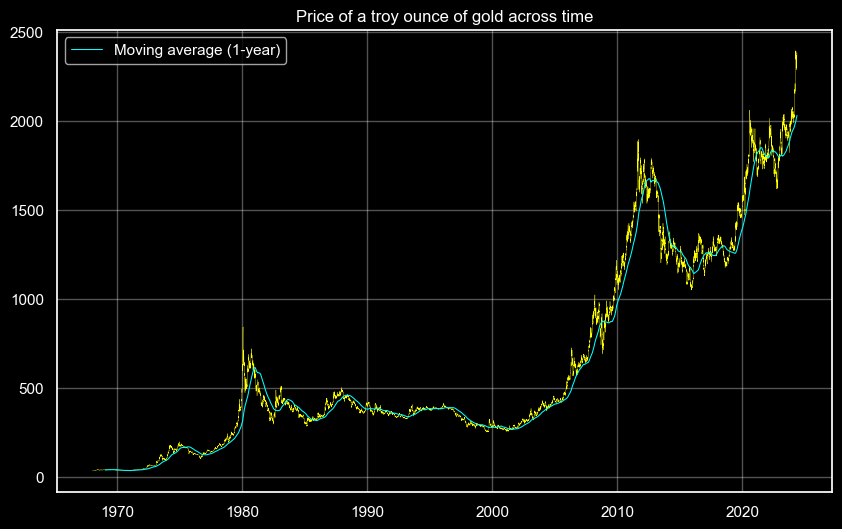

In [8]:
plt.figure(figsize=(10, 6))

sns.lineplot(data=df_au, x=df_au.index, y="price", color="yellow", linewidth=0.25)
sns.lineplot(data=df_au, x=df_au.index, y="price_1y_ma", label="Moving average (1-year)", color="aqua", linewidth=0.75)

plt.title("Price of a troy ounce of gold across time")
plt.xlabel("")
plt.ylabel("")

save_chart_as_png("1.1_AU_price")

**It's easier to see the early price fluctuations with a logarithmic scale on the y-axis**

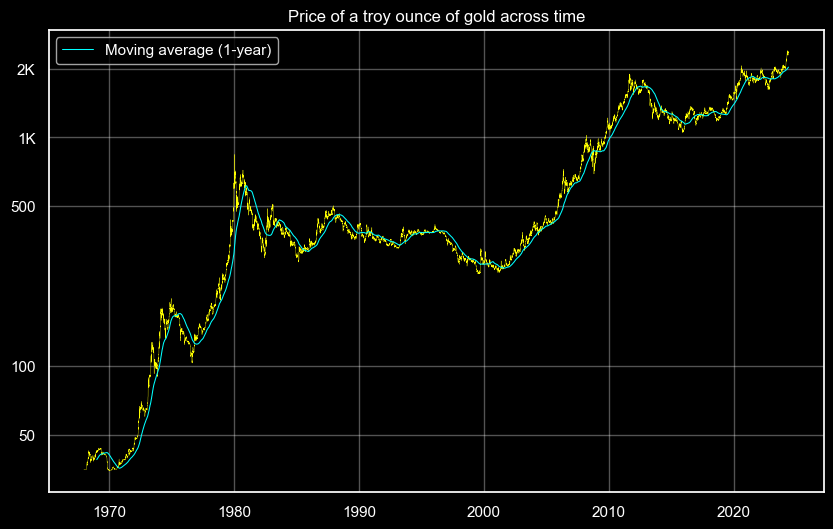

In [9]:
plt.figure(figsize=(10, 6))

sns.lineplot(data=df_au, x=df_au.index, y="price", color="yellow", linewidth=0.25)
sns.lineplot(data=df_au, x=df_au.index, y="price_1y_ma", label="Moving average (1-year)", color="aqua", linewidth=0.75)

plt.title("Price of a troy ounce of gold across time")
plt.xlabel("")
plt.ylabel("")

plt.yscale("log")

plt.gca().yaxis.set_major_formatter(
    FuncFormatter(lambda x, _: f"{int(x)}" if x < 1000 and x.is_integer() 
                  else (f"{x:.1f}" if x < 1 else f"{int(x/1000)}K"))
)
plt.yticks([50, 100, 500, 1000, 2000])

save_chart_as_png("1.1_AU_price_log")

In [10]:
# All-time high
ath_date = df_au["price"].idxmax()
df_au.loc[[ath_date]]

,price,price_1y_ma
date,,
2024-04-12,2394.8,1999.206349


In [11]:
# All-time low
atl_date = df_au["price"].idxmin()
df_au.loc[[atl_date]]

,price,price_1y_ma
date,,
1970-01-16,34.78,40.775


In [12]:
# Peaks
peaks, _ = signal.find_peaks(df_au["price"], distance=1000)
df_au.iloc[peaks].nlargest(12, "price").sort_values("date")[["price"]].T

date,1969-03-10,1974-12-30,1980-01-21,1987-12-14,1991-12-10,1996-02-02,2002-05-24,2006-05-12,2011-09-05,2016-05-03,2020-04-23,2024-04-12
price,43.75,197.5,843.0,502.75,370.75,416.25,320.9,725.75,1896.5,1296.5,1727.55,2394.8


In [13]:
# Valleys
valleys, _ = signal.find_peaks(-df_au["price"], distance=1000)
df_au.iloc[valleys].nsmallest(12, "price").sort_values("date")[["price"]].T

date,1970-01-16,1976-08-31,1981-03-05,1985-02-26,1989-02-17,1993-03-10,1999-07-21,2003-07-16,2007-07-06,2011-07-01,2015-12-03,2019-11-29
price,34.78,103.05,457.0,285.0,378.95,326.5,252.9,343.0,647.75,1492.75,1050.6,1456.35


In [14]:
# Price appreciation since first entry
first_entry_price = df_au.iloc[0]["price"]
last_entry_price = df_au.iloc[-1]["price"]
(last_entry_price - first_entry_price) / first_entry_price

66.70181921546333

**Key takeaways:**
- The all-time low occurred in 1970, with the price at approximately \$35.
- Prices surged rapidly from the early 1970s, following the collapse of the Bretton Woods system in 1973.
- Reached a peak in 1980 at around \$850.
- Experienced a decline over the next 20 years.
- Prices rose consistently until the early 2010s, peaking in 2011 at about \$1,500.
- Declined slightly until 2019, then started rising again.
- An all-time high was achieved in April 2024, with prices nearing \$2,400.
- The price of gold has appreciated by approximately 6,670% since the first entry.

### Price change year-over-year

In [15]:
# Get YoY returns
# Get yearly gold price df with first and last prices
df_au_yearly = df_au.groupby(df_au.index.year)["price"].agg(
    first_price="first",
    last_price="last"
)
# Get YoY return
df_au_yearly["price_change"] = (df_au_yearly["last_price"] - df_au_yearly["first_price"]) / df_au_yearly["first_price"]

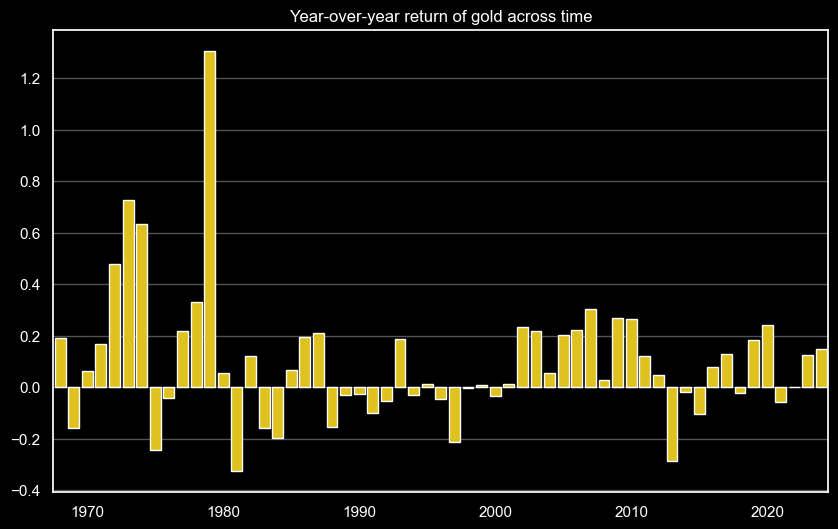

In [16]:
plt.figure(figsize=(10, 6))

sns.barplot(data=df_au_yearly, x=df_au_yearly.index, y="price_change", color="gold")

plt.title("Year-over-year return of gold across time")
plt.xlabel("")
plt.ylabel("")

# Show only beginning of decade
ax = plt.gca()
for index, label in enumerate(ax.get_xticklabels()):
    if index % 10 - 2 != 0:
        label.set_visible(False)

save_chart_as_png("1.1_AU_YoY_return")

In [17]:
# Highest YoY return
df_au_yearly.loc[[df_au_yearly["price_change"].idxmax()]]

,first_price,last_price,price_change
date,,,
1979,227.15,524.0,1.306846


In [18]:
# Lowest YoY return
df_au_yearly.loc[[df_au_yearly["price_change"].idxmin()]]

,first_price,last_price,price_change
date,,,
1981,592.0,400.0,-0.324324


In [19]:
# Average YoY return
df_au_yearly["price_change"].mean().round(4)

0.0979

In [20]:
# Average YoY return excluding 1979
df_au_yearly.loc[df_au_yearly.index != 1979,"price_change"].mean().round(4)

0.0763

In [21]:
# Median YoY return
round(df_au_yearly["price_change"].median(), 4)

0.0549

In [22]:
# Standard deviation YoY return
round(df_au_yearly["price_change"].std(), 4)

0.258

In [23]:
# Cumulative product YoY return
# This metric only differs from the "price appreciation since first entry" due to fluctuations between the price of last day of each year and the price of first day of the next year.
(1 + df_au_yearly["price_change"]).cumprod().iloc[-1].round(4) - 1

54.3506

In [24]:
# Get max, min, average, median, standard deviation and cumulative product YoY return per decade
df_au_yearly["decade"] = (df_au_yearly.index // 10) * 10
df_au_yearly.groupby("decade").agg(
    max_yoy_price_change=("price_change", lambda x: round(x.max(), 4)),
    min_yoy_price_change=("price_change", lambda x: round(x.min(), 4)),
    avg_yoy_price_change=("price_change", lambda x: round(x.mean(), 4)),
    median_yoy_price_change=("price_change", lambda x: round(x.median(), 4)),
    std_yoy_price_change=("price_change", lambda x: round(x.std(), 4)),
    cumprod_yoy_price_change=("price_change", lambda x: round((1 + x).cumprod().iloc[-1] - 1, 4)),
    dod_price_change=("decade", lambda x: (df_au_yearly.loc[x.index, "last_price"].iloc[-1] - df_au_yearly.loc[x.index, "first_price"].iloc[0]) / df_au_yearly.loc[x.index, "first_price"].iloc[0])
).T

decade,1960,1970,1980,1990,2000,2010,2020
max_yoy_price_change,0.192400,1.306800,0.209000,0.185900,0.3055,0.267100,0.243700
min_yoy_price_change,-0.157700,-0.241900,-0.324300,-0.213700,-0.0333,-0.285500,-0.057300
avg_yoy_price_change,0.017400,0.364500,-0.021100,-0.026100,0.1513,0.039700,0.092000
median_yoy_price_change,0.017400,0.274200,0.012000,-0.029100,0.2106,0.063500,0.123900
std_yoy_price_change,0.247600,0.445900,0.180200,0.100100,0.1219,0.157000,0.120000
cumprod_yoy_price_change,0.004400,13.102100,-0.312600,-0.267900,2.8856,0.318800,0.515300
dod_price_change,0.000853,13.916026,-0.282648,-0.275862,2.9142,0.368374,0.566374


**Key takeaways:**
- In 1979, gold achieved a remarkable year-over-year return of 130%.
- Two years later, gold experienced its lowest return, dropping approximately 32.4%.
- The average annual return for gold has been around 9.8%, with a median return of about 5.5%.
- The 1970s were the most lucrative decade for gold, boasting an average annual return of 36.5%.
- During the 1980s and 1990s, gold's performance lagged, with an average annual return of around -2%.
- The 2000s delivered strong performance, with an average annual return of 15.1% and a median return of 21%.
- The current decade has shown promising results so far, with an average annual return of 9.2% and a median return of 12.4%.

### Yearly volatility (exponentially weighted moving average method)

In [25]:
# Get log returns
df_au["log_returns"] = np.log(df_au["price"] / df_au["price"].shift(1))

In [26]:
# Biggest price changes
df_au.loc[df_au["log_returns"].abs().sort_values(ascending=False).head(10).index, ["log_returns"]].T

date,1980-01-23,1980-03-14,1980-01-18,1980-01-03,1980-01-16,1983-02-28,1982-09-03,1972-06-12,1974-01-21,1980-01-22
log_returns,-0.160286,-0.133059,0.125345,0.12274,0.114846,-0.114668,0.107868,-0.106038,0.102425,-0.099709


In [27]:
# Get yearly volatility with the exponentially weighted moving average method
df_au["volatility_1y"] = df_au["log_returns"].ewm(span=252).std()

In [28]:
# Change first year values to NaN to avoid having unreliable volatility measures
df_au.loc[:df_au.index[251], "volatility_1y"] = np.nan

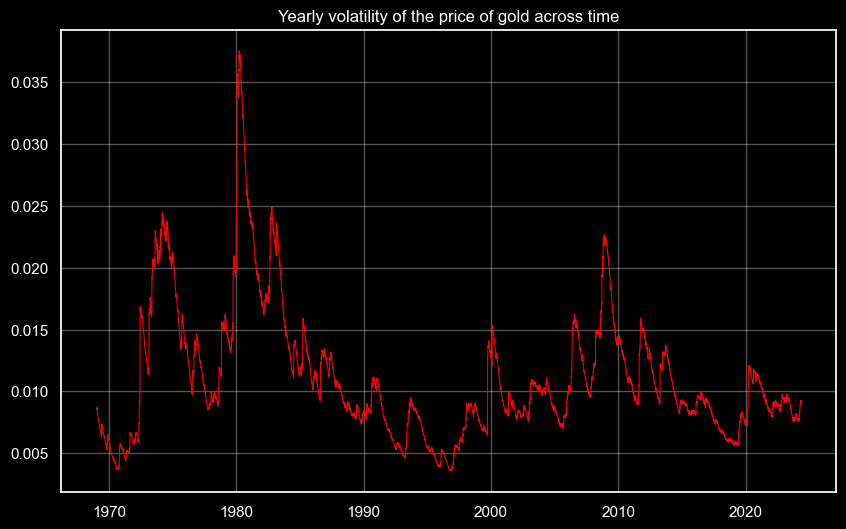

In [29]:
plt.figure(figsize=(10, 6))

sns.lineplot(data=df_au, x=df_au.index, y="volatility_1y", color="red", linewidth=0.75)

plt.title("Yearly volatility of the price of gold across time")
plt.xlabel("")
plt.ylabel("")

save_chart_as_png("1.1_AU_Y_vlt")

In [30]:
# All-time high
ath_date = df_au["volatility_1y"].idxmax()
df_au.loc[[ath_date], ["price", "volatility_1y"]]

,price,volatility_1y
date,,
1980-03-27,486.0,0.03755


In [31]:
# All-time low
atl_date = df_au["volatility_1y"].idxmin()
df_au.loc[[atl_date], ["price", "volatility_1y"]]

,price,volatility_1y
date,,
1996-12-02,370.5,0.003572


In [32]:
# Top 5 peaks
peaks, _ = signal.find_peaks(df_au["volatility_1y"], distance=500)
df_au.iloc[peaks].nlargest(5, "volatility_1y").sort_values("date")[["volatility_1y"]].T

date,1974-03-11,1980-03-27,1982-10-19,2006-07-24,2008-11-24
volatility_1y,0.024462,0.03755,0.024927,0.016267,0.022671


In [33]:
# Top 5 valleys
valleys, _ = signal.find_peaks(-df_au["volatility_1y"], distance=500)
df_au.iloc[valleys].nsmallest(5, "volatility_1y").sort_values("date")[["volatility_1y"]].T

date,1970-08-26,1993-03-29,1996-12-02,1999-09-21,2019-05-30
volatility_1y,0.003674,0.004605,0.003572,0.006458,0.005584


In [34]:
# Average 1-year volatility
df_au["volatility_1y"].mean().round(3)

0.011

In [35]:
# Average 1-year volatility per decade
df_au_dec = df_au.groupby((df_au.index.year // 10) * 10)
df_au_dec = df_au_dec["volatility_1y"].mean().round(3).reset_index()
df_au_dec.columns = ["decade", "average_volatility_1y"]
df_au_dec.set_index("decade").T

decade,1960,1970,1980,1990,2000,2010,2020
average_volatility_1y,0.007,0.013,0.016,0.007,0.012,0.01,0.009


**Key takeaways:**
- The largest five daily price changes occurred at the beginning of 1980.
- The average yearly volatility is 1.1%.
- The all-time low occurred in 1996, whereas the all-time high was observed in 1980, which was more than tenfold higher.
- Volatility significantly increased following the collapse of the Bretton Woods system in 1973.
- The market was highly volatile from the mid-1970s through the early 1980s, and during the dotcom bubble, the Great Recession, and the EU sovereign debt crisis.
- The market remained very stable during the 1990s, and also during the current decade excluding the pandemic period.

### STL decomposition (trend, seasonality, and residuals)

In [36]:
stl = STL(df_au["price"], period=252).fit()

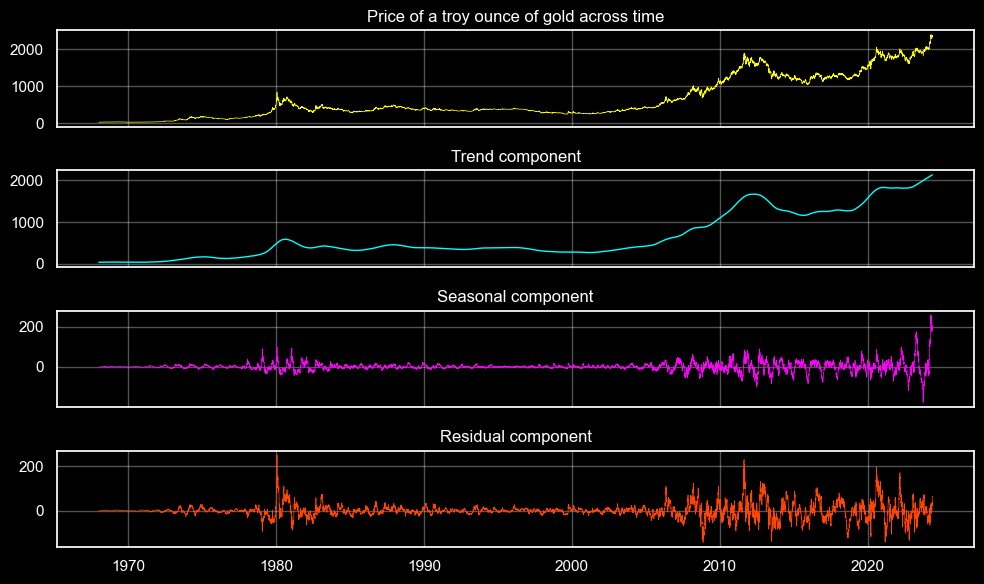

In [37]:
fig, axes = plt.subplots(4, 1, figsize=(10, 6), sharex=True)

axes[0].plot(df_au.index, df_au["price"], label="Original", color="yellow", linewidth=0.5)
axes[0].set_title("Price of a troy ounce of gold across time")

axes[1].plot(df_au.index, stl.trend, label="Trend", color="aqua", linewidth=1)
axes[1].set_title("Trend component")

axes[2].plot(df_au.index, stl.seasonal, label="Seasonal", color="fuchsia", linewidth=0.5)
axes[2].set_title("Seasonal component")

axes[3].plot(df_au.index, stl.resid, label="Residual", color="orangered", linewidth=0.5)
axes[3].set_title("Residual component")

plt.tight_layout()

#### Trend analysis

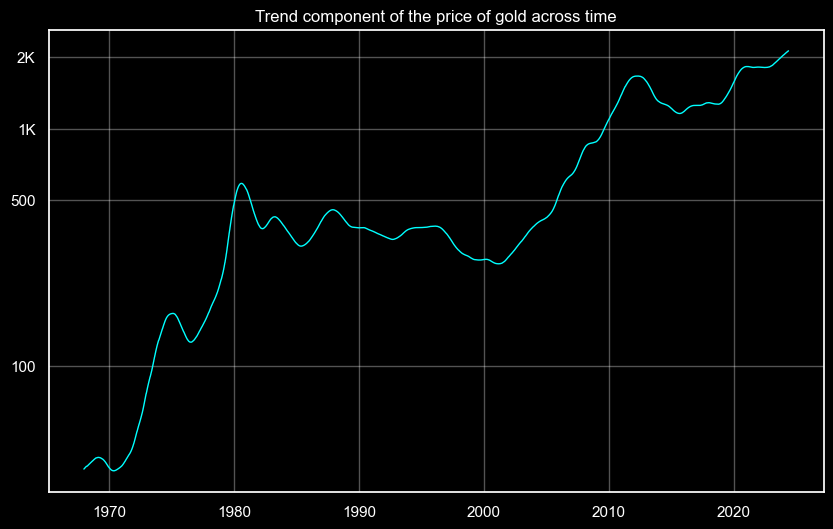

In [38]:
plt.figure(figsize=(10, 6))

plt.plot(stl.trend, color="aqua", linewidth=1)

plt.title("Trend component of the price of gold across time")
plt.xlabel("")
plt.ylabel("")

plt.yscale("log")

plt.gca().yaxis.set_major_formatter(
    FuncFormatter(lambda x, _: f"{int(x)}" if x < 1000 and x.is_integer() 
                  else (f"{x:.1f}" if x < 1 else f"{int(x/1000)}K"))
)
plt.yticks([100, 500, 1000, 2000])

save_chart_as_png("1.1_AU_trend")

**Key takeaways:**
- The trend experienced significant growth during the 1970s.
- There was a slow decline over the following 20 years.
- Since then, it has been rising with notable consistency.

#### Seasonality analysis

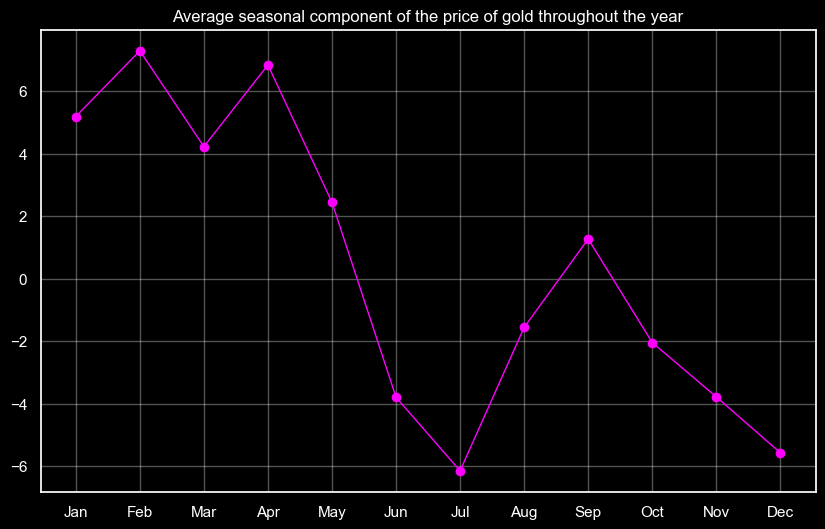

In [39]:
seasonal = stl.seasonal
monthly_avgs = seasonal.groupby(seasonal.index.month).mean()

plt.figure(figsize=(10, 6))

plt.plot(monthly_avgs.index, monthly_avgs.values, marker='o', color="fuchsia", linewidth=1)

plt.title("Average seasonal component of the price of gold throughout the year")
plt.xlabel("")
plt.ylabel("")

plt.xticks(monthly_avgs.index, [calendar.month_abbr[i] for i in monthly_avgs.index])

save_chart_as_png("1.1_AU_seasonal")

**Key takeaways:**
- Seasonal patterns exhibit variations over the years.
- Based on monthly averages, it reveals favorable seasons during the first four months of the year and in September.
- Some analysts suggest that gold experiences a strong seasonal phase starting in mid-November, extending until the second half of February.

## Price of gold year-to-date (short-term analysis)

In [40]:
# Get YTD df
df_au_ytd = df_au["2024":].copy()

In [41]:
# Get price change
df_au_ytd["price_change"] = df_au_ytd["price"].pct_change()

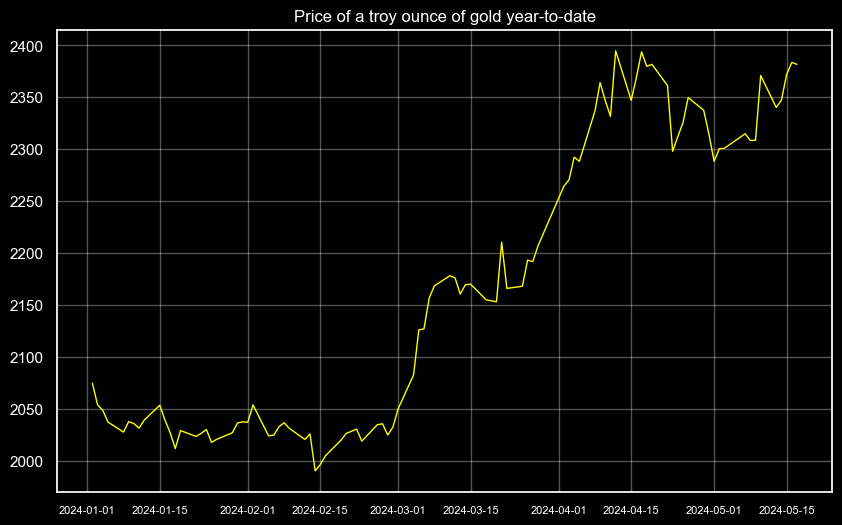

In [42]:
plt.figure(figsize=(10, 6))

sns.lineplot(data=df_au_ytd, x=df_au_ytd.index, y="price", color="yellow", linewidth=1)

plt.xticks(fontsize=8)

plt.title("Price of a troy ounce of gold year-to-date")
plt.xlabel("")
plt.ylabel("")

save_chart_as_png("1.1_AU_price_YTD")

In [43]:
# Price change YTD
first_price = df_au_ytd.iloc[0]["price"]
last_price = df_au_ytd.iloc[-1]["price"]
(last_price - first_price) / first_price

0.14788664513952474

In [44]:
# When the price quickly began to rise
rise_start = df_au_ytd.loc[df_au_ytd["price"].diff() > 20].index[0]
df_au_ytd.loc[[rise_start], ["price", "price_change"]].round(2)

,price,price_change
date,,
2024-03-04,2083.15,0.02


In [45]:
# When the price peaked (which is also the ATH)
peak_date = df_au_ytd["price"].idxmax()
df_au_ytd.loc[[peak_date], ["price", "price_change"]].round(2)

,price,price_change
date,,
2024-04-12,2394.8,0.03


In [46]:
# Average daily price change during the rise
df_au_ytd.loc[rise_start:peak_date]["price_change"].mean().round(5)

0.00563

In [47]:
# Average price before the rise
avg_price_before = df_au_ytd.loc[:rise_start]["price"].mean().round(0)
avg_price_before

2032.0

In [48]:
# Average price after the peak
avg_price_after = df_au_ytd.loc[peak_date:]["price"].mean().round(0)
avg_price_after

2343.0

In [49]:
# Difference between the average prices
((avg_price_after - avg_price_before) / avg_price_before).round(3)

0.153

**Key takeaways:**
- The year-to-date price change stands at a notable 17.4%, showcasing strong market movement.
- Before the breakout, the average price hovered around \$2,032.
- The breakout occurred in early March.
- Post-breakout, the price grew quickly, averaging a daily increase of approximately 0.5%.
- By mid-April, the price peaked at \$2,400.
- After reaching all-time high in mid-April, the average price has since stabilized around \$2,343, suggesting a period of consolidation.

### Weekly volatility

In [50]:
# Get weekly volatility with the exponentially weighted moving average method
df_au_ytd["volatility_1w"] = df_au_ytd["log_returns"].ewm(span=5).std()

In [51]:
# Change first week values to NaN to avoid having unreliable volatility measures
df_au_ytd.loc[:df_au_ytd.index[4], "volatility_1w"] = np.nan

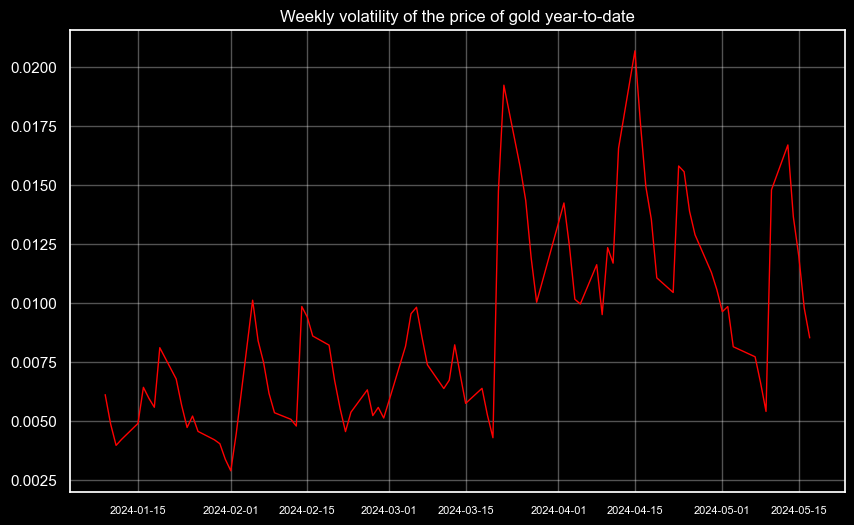

In [52]:
plt.figure(figsize=(10, 6))

sns.lineplot(data=df_au_ytd, x=df_au_ytd.index, y="volatility_1w", color="red", linewidth=1)

plt.xticks(fontsize=8)

plt.title("Weekly volatility of the price of gold year-to-date")
plt.xlabel("")
plt.ylabel("")

save_chart_as_png("1.1_AU_W_vlt_YTD")

In [53]:
# Breakout point
breakout_date = df_au_ytd[df_au_ytd["volatility_1w"] > 0.0125].index[0]
df_au_ytd.loc[[breakout_date], ["price", "price_change", "volatility_1w"]].round(2)

,price,price_change,volatility_1w
date,,,
2024-03-21,2210.65,0.03,0.01


In [54]:
# Average volatility before breakout
avg_vol_before = df_au_ytd.loc[:breakout_date - pd.Timedelta(days=1)]["volatility_1w"].mean().round(3)
avg_vol_before

0.006

In [55]:
# Average volatility after breakout
avg_vol_after = df_au_ytd.loc[breakout_date:]["volatility_1w"].mean().round(3)
avg_vol_after

0.012

In [56]:
# Percent change between the average volatilities
((avg_vol_after - avg_vol_before) / avg_vol_before).round(3)

1.0

**Key takeaways:**
- In the beginning, weekly volatility averaged at 0.6%, indicating relative stability.
- A breakout occurred on March 21st, dramatically altering the landscape.
- Following the breakout, the average volatility surged to 1.2%, doubling its previous level.